# AR construction for 3D Van de Vusse kinetics

## Python imports

In [1]:
import scipy as sp
from scipy.integrate import odeint

import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')

# import artools for convenience functions
import sys
sys.path.append('../')
import artools
artools = reload(artools)

## Define Van de Vusse rate vector and feed point

In [2]:
Cf = sp.array([1.0, 0.0, 0.0])

def rate_fn(C, t):
    k1 = 1.0
    k2 = 1.0
    k3 = 10.0
    
    cA = C[0]
    cB = C[1]
    
    rA = -k1*cA - 2*k3*cA**2
    rB = k1*cA - k2*cB
    rD = k3*cA**2

    return sp.array([rA, rB, rD])

## Define critical $\alpha$ and DSR functions

The critical $\alpha$ expression is based on the 'VdelR' condition discussed in chapter 6. `alpha_fn()` takes two parameters: `C` and `C0` (the DSR mixing point). `dsr_fn()` is the dsr function to be integrated. `C0` is an additional paramter that must be passed in.

In [3]:
def alpha_fn(C, C0):
    c_A = C[0]
    c_B = C[1]

    c_A0 = C0[0]
    c_B0 = C0[1]

    e = -c_A*(20*c_A**3*c_B + 20*c_A**3*c_B0 - 80*c_A**2*c_A0*c_B - c_A**2*c_A0 + 3*c_A**2*c_B0 + 40*c_A*c_A0**2*c_B + c_A*c_A0**2 - 3*c_A*c_A0*c_B - 2*c_A*c_A0*c_B0 + 2*c_A0**2*c_B)/(2*c_A**3*c_B0 - 2*c_A**2*c_A0*c_B - 4*c_A**2*c_A0*c_B0 + 4*c_A*c_A0**2*c_B + 2*c_A*c_A0**2*c_B0 - 2*c_A0**3*c_B)
    return e


def dsr_fn(C, t, C0):
    return rate_fn(C, t) + alpha_fn(C, C0)*(C0 - C)

## Define feed point and calculate PFR and CSTR from the feed

C:\Users\a0017697\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


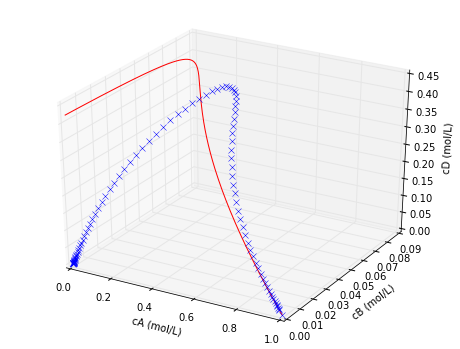

In [4]:
# PFR from the point
pfr_cs, pfr_ts = artools.calc_pfr_trajectory(Cf, rate_fn, 10.0)

# CSTR from feed point
cstr_cs, cstr_ts = artools.calc_cstr_locus_fast(Cf, rate_fn, 1e4, 100)

# plot
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")

ax.plot(pfr_cs[:, 0], pfr_cs[:, 1], pfr_cs[:, 2], "r-")
ax.plot(cstr_cs[:, 0], cstr_cs[:, 1], cstr_cs[:, 2], "bx")

ax.set_xlabel("cA (mol/L)")
ax.set_ylabel("cB (mol/L)")
ax.set_zlabel("cD (mol/L)")

plt.show(fig)

## Plot critical DSRs

We know that there are two critical DSRs for the Van de Vusse system. The first DSR starts at the feed. Note that the $\alpha$ is undefined at the feed, and so we need to offset the initial concentration for the first critical DSR slightly. Thus, instead of using Cf as the feed concentration to the DSR, we use a point from the PFR trajectory near the feed (such as the second PFR point in `pfr_cs`)

In [5]:
# DSR from feed point
C0 = Cf
dsr1_Cf = pfr_cs[2, :]

Now we can integrate and plot as usual. Remember that `dsr_fn()` takes the DSR mixing concentration `C0` as an additional argument that must be passed in using the `args` parameter in SciPy's `odeint()` function.

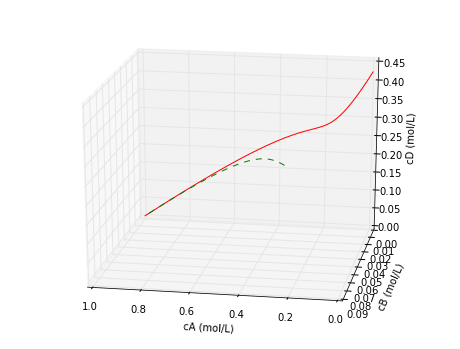

In [6]:
dsr1_ts = sp.logspace(-3, sp.log10(5), 100)
dsr1_cs = odeint(dsr_fn, dsr1_Cf, dsr1_ts, args=(C0,))

# update plot
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")

ax.plot(pfr_cs[:, 0], pfr_cs[:, 1], pfr_cs[:, 2], "r-")
#ax.plot(cstr_cs[:, 0], cstr_cs[:, 1], cstr_cs[:, 2], "bx")
ax.plot(dsr1_cs[:, 0], dsr1_cs[:, 1], dsr1_cs[:, 2], "g--")

ax.set_xlabel("cA (mol/L)")
ax.set_ylabel("cB (mol/L)")
ax.set_zlabel("cD (mol/L)")

ax.view_init(20, 100)

plt.show(fig)

The second critical DSR occurs at the CSTR equilibrium point. Thus, we can approximate the CSTR equilbrium point by taking very large CSTR residence times, and then use the correspoding CSTR effluent concentration as the feed to the second critical DSR.

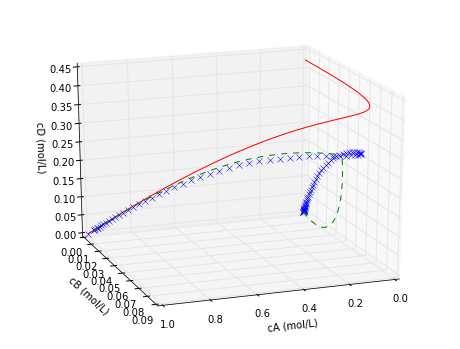

In [7]:
# DSR from CSTR equilibrium pt
dsr2_Cf = cstr_cs[-1, :]
dsr2_ts = sp.logspace(-3, sp.log10(15), 400)
dsr2_cs = odeint(dsr_fn, dsr2_Cf, dsr2_ts, args=(C0,))

# plot trajectories
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
fig.hold(True)

ax.plot(pfr_cs[:, 0], pfr_cs[:, 1], pfr_cs[:, 2], "r-")
ax.plot(cstr_cs[:, 0], cstr_cs[:, 1], cstr_cs[:, 2], "bx")
ax.plot(dsr1_cs[:, 0], dsr1_cs[:, 1], dsr1_cs[:, 2], "g--")
ax.plot(dsr2_cs[:, 0], dsr2_cs[:, 1], dsr2_cs[:, 2], "g--")

ax.set_xlabel("cA (mol/L)")
ax.set_ylabel("cB (mol/L)")
ax.set_zlabel("cD (mol/L)")

ax.view_init(20, 70)

plt.show(fig)

We can initiate PFR trajectories from the two critical DSR trjectories to fill out the region

In [8]:
all_cs = Cf

for i in range(0, dsr1_cs.shape[0], 10):
    ci = dsr1_cs[i, :]
    tmp_cs, tmp_ts = artools.calc_pfr_trajectory(ci, rate_fn, 10, NUM_PTS=50)
    all_cs = sp.vstack([all_cs, tmp_cs])
    
for i in range(0, dsr2_cs.shape[0], 5):
    ci = dsr2_cs[i, :]
    tmp_cs, tmp_ts = artools.calc_pfr_trajectory(ci, rate_fn, 10, NUM_PTS=50)
    all_cs = sp.vstack([all_cs, tmp_cs])

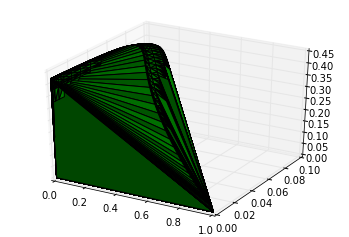

In [9]:
import scipy.spatial
import matplotlib.tri as mtri

conv_cs = artools.convhull_pts(all_cs)
#%matplotlib qt
fig = plt.figure()
ax = fig.gca(projection="3d")

Vs = conv_cs
color="g"
alpha=1.0

simplices = scipy.spatial.ConvexHull(Vs).simplices
xs = Vs[:, 0]
ys = Vs[:, 1]
zs = Vs[:, 2]
ax.plot_trisurf(mtri.Triangulation(xs, ys, simplices), zs,
                color=color,
                alpha=alpha)

plt.show(fig)

## Test the validity of using any point in the lineations of the AR boundary as mixing points for the DSR. 

According to Theorem 2, you could use any point obtained from a mixing line on the AR boundary (points from protrusions i.e. PFR trajectories are not allowed). I'm not sure why this doesn't work though.

## Mix between feed point and some random point on DSR 1.

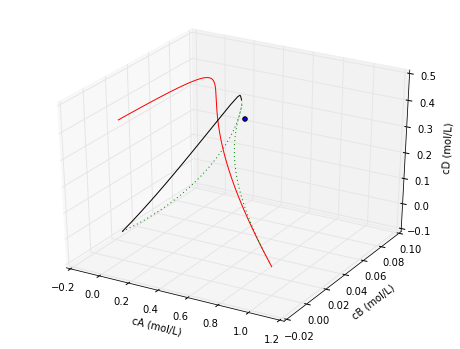

In [10]:
L = 0.9
C_mix = Cf + L*(dsr1_cs[90, :] - Cf)

# dsr from feed point with C0 = C_mix and not Cf
C0 = C_mix
dsr_new_Cf = cstr_cs[-1,:]

dsr_new_ts = sp.logspace(-3, sp.log10(20), 300)
dsr_new_cs = odeint(dsr_fn, dsr_new_Cf, dsr_new_ts, args=(C0,))

#%matplotlib qt
# plot trajectories
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
fig.hold(True)

ax.plot(pfr_cs[:, 0], pfr_cs[:, 1], pfr_cs[:, 2], "r-")
ax.plot(dsr1_cs[:, 0], dsr1_cs[:, 1], dsr1_cs[:, 2], "g:")
ax.plot(dsr2_cs[:, 0], dsr2_cs[:, 1], dsr2_cs[:, 2], "g:")
ax.plot(dsr_new_cs[:, 0], dsr_new_cs[:, 1], dsr_new_cs[:, 2], "k-")
ax.scatter(C_mix[0], C_mix[1], C_mix[2], "bo")

ax.set_xlabel("cA (mol/L)")
ax.set_ylabel("cB (mol/L)")
ax.set_zlabel("cD (mol/L)")

plt.show(fig)

In [11]:
C_mix

array([ 0.31692679,  0.07580749,  0.28569386])

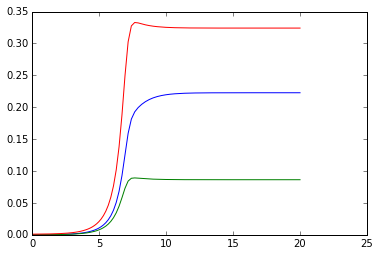

In [12]:
fig = plt.figure()

plt.plot(dsr_new_ts, dsr_new_cs)